In [1]:
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import spotipy

from skimage import io
from spotipy.oauth2 import SpotifyClientCredentials

# PACKAGE VERSIONS
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Pandas version: {pd.__version__}")
# print(f"Spotify version: {spotipy.__version__}") # Doesnt exist???

# GET CONFIG
config_file = "settings.yml"
with open(config_file, "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

Matplotlib version: 3.6.3
Pandas version: 2.1.1


In [2]:
# PARAMS
start_artist_name = "TRISTAM"
connection_depth = 3

In [3]:
# SPOTIFY AUTH
spotify_creds = cfg["spotify_creds"]
sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id=spotify_creds["client_id"],
        client_secret=spotify_creds["client_secret"],
    )
)

Multiple artists found, picking the most popular one:
Artist ID: 28Ky95tmlHktB96DBUoB0g


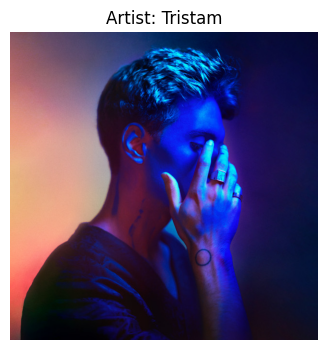

In [4]:
# GET START ARTIST
results = sp.search(q=f"artist:{start_artist_name}", type="artist")["artists"]

if len(results["items"]) == 0:
    raise ValueError(f"No artist found with name: {start_artist_name}")

if len(results["items"]) > 1:
    print(f"Multiple artists found, picking the most popular one:")

start_artist = results["items"][0]
print(f"Artist ID: {start_artist['id']}")

plt.figure(figsize=(4, 4))
plt.title(f"Artist: {start_artist['name']}")
plt.imshow(io.imread(start_artist["images"][0]["url"]))
plt.axis("off")
plt.show()

In [5]:
# FIND ALL POSSIBLE RELEASES
releases = []
n_singles = 0
while True:
    response = sp.artist_albums(start_artist["id"], limit=50, offset=n_singles)
    releases.extend(response["items"])
    if not response["next"]:
        break
    n_singles += 50

# FILTER OUT RELEASES ON ARTIST ID
clean_releases = []
for release in releases:
    for artist in release["artists"]:
        if artist["id"] == start_artist["id"]:
            clean_releases.append(release)
            break

# GET ALL TRACKS FROM ALL RELEASES
tracks = []
n_tracks = 0
for release in clean_releases:
    while True:
        response = sp.album_tracks(release["id"], limit=50, offset=n_tracks)
        tracks.extend(response["items"])
        if not response["next"]:
            break
        n_tracks += 50

# REMOVE DUPLICATES
unique_tracks = []
for track in tracks:
    if track["name"] not in [t["name"] for t in unique_tracks]:
        unique_tracks.append(track)
tracks = unique_tracks

# GET ALL ARTISTS FROM ALL TRACKS
related_artists = []
for track in unique_tracks:
    for artist in track["artists"]:
        if artist["id"] != start_artist["id"]:
            related_artists.append(artist)

# REMOVE DUPLICATES
unique_related_artists = []
for artist in related_artists:
    if artist["id"] not in [a["id"] for a in unique_related_artists]:
        unique_related_artists.append(artist)
related_artists = unique_related_artists

In [6]:
# GET ALL ARTISTS IN ALL TRACKS
artist_track = pd.DataFrame(
    [
        {"track_id": track["id"], "artist_id": artist["id"]}
        for track in tracks
        for artist in track["artists"]
    ]
)
artist_track

,track_id,artist_id
0,6WeCNrVIIGnmWH9LX5NpeH,28Ky95tmlHktB96DBUoB0g
1,7pGzKqXUQHhG2L0kz3PtEl,28Ky95tmlHktB96DBUoB0g
2,3pknIeXAx0kwpNhoApURlk,28Ky95tmlHktB96DBUoB0g
3,1qDIHChIQ0MJnn6KC6EWZL,28Ky95tmlHktB96DBUoB0g
4,4fj3I6UOb37rOttjJackdj,28Ky95tmlHktB96DBUoB0g
...,...,...
60,7lVRzpcslPCVXFw0HZqXMH,28Ky95tmlHktB96DBUoB0g
61,1AXV9pe20iRU68GAOx7fDL,28Ky95tmlHktB96DBUoB0g
62,7x3eAzSN9IZ5b63PIRUaGj,28Ky95tmlHktB96DBUoB0g
63,7xausdQWGTyEIU3XX0VJCP,28Ky95tmlHktB96DBUoB0g


In [7]:
# GET ALL ARTIST NAMES
artist_names = pd.DataFrame(
    [{"artist_id": artist["id"], "artist_name": artist["name"]} for track in tracks for artist in track["artists"]]
)
artist_names = artist_names.drop_duplicates().reset_index(drop=True)
artist_names

,artist_id,artist_name
0,28Ky95tmlHktB96DBUoB0g,Tristam
1,1SFSz2SewAsgPeFvGmAouI,Braken
2,0lLY20XpZ9yDobkbHI7u1y,Pegboard Nerds
3,0FvgCHaMG7KL6M83yJuhmL,Stephen Walking
4,3zuevuwyBq4MiQzPB3nvW2,Rogue
5,4qBBiiVp1wDaSjF1celzPa,Zealot
6,20b8byuiw8eOd0KuBs0VVF,Clean Kill
7,61x5cjLl8p34OfhV0B80TB,Miggel
8,7KY48sVkBRqkcl8fdghjRX,Chantal Laveridiere


In [8]:
# GET INFO ON ALL THE TRACKS
tracks = pd.DataFrame(tracks)
tracks = tracks.loc[:, ["id", "name"]]
tracks

tracks_info = pd.DataFrame(sp.audio_features(tracks["id"].tolist()))
tracks_info = tracks_info.loc[:, ["id", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]]
tracks_info

tracks = pd.merge(tracks, tracks_info, on="id")
tracks

,id,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,6WeCNrVIIGnmWH9LX5NpeH,Black Beauty,0.492,0.342,3,-9.919,0,0.0411,0.933000,0.001090,0.1130,0.2080,149.456,227353,4
1,7pGzKqXUQHhG2L0kz3PtEl,Ruthless,0.491,0.871,9,-4.261,0,0.1170,0.465000,0.000000,0.1910,0.3200,134.758,186667,4
2,3pknIeXAx0kwpNhoApURlk,Mistake,0.535,0.795,5,-6.375,0,0.0810,0.313000,0.000000,0.1250,0.4710,99.838,206400,4
3,1qDIHChIQ0MJnn6KC6EWZL,Children in the Dark,0.369,0.619,8,-6.500,1,0.0545,0.679000,0.000006,0.1290,0.2770,97.779,212700,4
4,4fj3I6UOb37rOttjJackdj,Burn,0.360,0.443,1,-7.326,1,0.0510,0.719000,0.000029,0.0961,0.3530,173.343,194483,4
5,4dY0uLGhBmyiKR6TqbGwLe,1992,0.640,0.577,1,-8.873,1,0.0750,0.813000,0.003150,0.0981,0.2320,90.951,203793,4
6,4FYLrL7cJVkR4JCLyqwIZ8,Over the Edge,0.627,0.582,11,-8.505,1,0.0827,0.623000,0.000010,0.1490,0.3640,97.025,197938,4
7,1B8oRPZhb3eXH2bB8jsF4k,Take a Chance,0.531,0.471,6,-6.984,1,0.0285,0.591000,0.003870,0.1220,0.1430,95.064,174316,4
8,1ZfnRyzIdm6TWaWQUGvt1q,Different,0.435,0.493,1,-6.002,0,0.0394,0.823000,0.000090,0.1050,0.2020,159.745,243467,3
9,3HltbvkfjVeyjESx3JbuLD,Violence,0.300,0.546,1,-7.708,1,0.0405,0.714000,0.000003,0.0897,0.2740,154.533,213677,4
